In [1]:
from sklearn.decomposition import PCA
import xarray as xr
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
### Function as the primitive of the generator of the array

#b = points[:,0,0].where(points['time.year'] == 2005, drop=True).values
#b = b.reshape(1, b.shape[0])
#b.shape
#
#for i, y in enumerate(years):
#    c = points[:,0,0].where(points['time.year'] == y, drop=True).values
#    c = c.reshape(1, c.shape[0])
#    
#    if c.shape[1] != 53:
#        c = np.append(c, 0)
#        
#    b = np.vstack([b,c])

In [2]:
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-40, 40.),
        'lat' : (65, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [3]:
## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a dictionary.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
            
        dictionary: dic
            name of the dictionary wwith the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """

    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))



def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        t : integer
            Timestep to plot.
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
        
        ext : string
            Extention of the color bar. Default is 'max'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)

def magnitude(a, b):
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    return xr.apply_ufunc(func, a, b)

def Normalize(data_set):
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    
    y = lambda x, mn, mx: (x - mn) / (mx - mn)
    return(xr.apply_ufunc(y, data_set, mn, mx ))

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../New_ARMOR/'
#dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
#fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
#c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

/venv/py3-phyocean/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/venv/py3-phyocean/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/venv/py3-phyocean/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/venv/py3-phyocean/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationW

In [5]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

In [50]:
coord = 'gul'
region = Crops(coord, c_armor1, reg_ext)

In [129]:
points = region.mlotst[:,::4,::20]

In [130]:
p2 = points.stack(map=('longitude', 'latitude'))

In [131]:
## Exclude 2018 because is not a full year
years = [y for y in range(2005, 2018)]

In [132]:
maps = p2.map.size
b = np.zeros((1,53))

In [133]:
for m in range(maps):
    for i, y in enumerate(years):
        c = p2[:,m].where(p2['time.year'] == y, drop=True).values
        c = c.reshape(1, c.shape[0])
        #print(c.shape)

        if c.shape[1] != 53:
            c = np.append(c, 0)

        b = np.vstack([b,c])

In [134]:
g = np.delete(b, 0, 0)

In [144]:
ds = xr.DataArray(g, dims=['year_4_point', 'n_week'], name='MLD_point').to_dataset()
data_set = ds.dropna(dim='year_4_point', how='any')

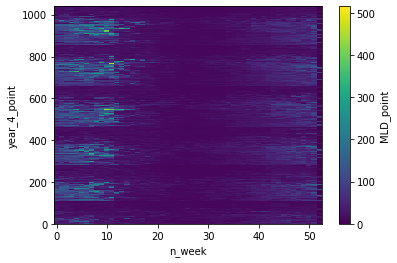

In [145]:
data_set.MLD_point.plot()

In [152]:
data_set

<xarray.Dataset>
Dimensions:    (n_week: 53, year_4_point: 1040)
Dimensions without coordinates: n_week, year_4_point
Data variables:
    MLD_point  (year_4_point, n_week) float64 42.0 37.0 46.0 ... 14.0 19.0 0.0

In [ ]:
#mx = ds.MLD_point.max(skipna=True)
#mn = ds.MLD_point.min(skipna=True)
#norm = Normalize(ds)

here, trying to have the shifted values, starting by the maximum

In [149]:
max_w = data_set.MLD_point.groupby('year_4_point').argmax(dim='n_week', skipna=True)
max_w.values

array([8, 4, 4, ..., 6, 3, 5])

In [156]:
r = max_w[0].values
s = data_set.MLD_point[0]

s = Normalize(s)

shift = np.roll(s, -r)
shift = shift.reshape(1, shift.shape[0])

In [159]:
for i in range(1, data_set.year_4_point.size):
    r = max_w[i].values
    s = data_set.MLD_point[i]
    
    s = Normalize(s)
    
    sh = np.roll(s, -r)
    sh = sh.reshape(1, sh.shape[0])
    shift = np.vstack([shift,sh])

In [204]:
shifted = xr.DataArray(shift, dims=['year_4_point', 'week'], name='MLD').to_dataset()
shifted

<xarray.Dataset>
Dimensions:  (week: 53, year_4_point: 2079)
Dimensions without coordinates: week, year_4_point
Data variables:
    MLD      (year_4_point, week) float64 1.0 0.1465 0.05732 ... 0.6471 0.7059

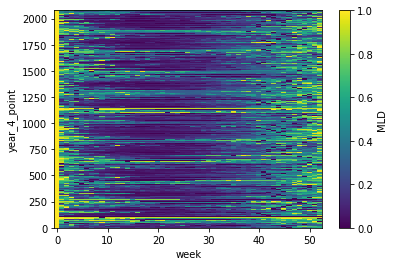

In [205]:
shifted.MLD.plot()

Here, appliying PCA. Over the dataset called shifted. 
Shifted contains all max in the same week slot and it is also normalized.

In [206]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca = PCA(n_components=n_components)
pca.fit(shifted.MLD)

PCA(n_components=12)

In [207]:
print(pca.explained_variance_ratio_)

[0.40990465 0.10870276 0.07586874 0.04058606 0.03396271 0.02765892
 0.02316305 0.02061579 0.01789182 0.01669706 0.01552328 0.01525741]


In [208]:
print(pca.singular_values_)

[44.66240795 22.99963739 19.21463571 14.05365005 12.85588297 11.60161135
 10.61691986 10.01614723  9.33099537  9.01406542  8.69145343  8.61670274]


In [209]:
reduced_values = pca.transform(shifted.MLD)

In [210]:
print(pca.components_.size)

636


In [211]:
# Put all components_ analysis data to the dataset
shifted['reduced_data'] = xr.DataArray(reduced_values, dims=['sample', 'n_eof'])
shifted['eigen_values'] = xr.DataArray(pca.components_, dims=['n_eof', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
shifted['explained_variance'] = xr.DataArray(pca.explained_variance_ratio_*100, 
                                        dims=['n_eof'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

In [212]:
shifted

<xarray.Dataset>
Dimensions:             (n_eof: 12, sample: 2079, week: 53, year_4_point: 2079)
Dimensions without coordinates: n_eof, sample, week, year_4_point
Data variables:
    MLD                 (year_4_point, week) float64 1.0 0.1465 ... 0.7059
    reduced_data        (sample, n_eof) float64 -1.233 -0.07767 ... -0.02796
    eigen_values        (n_eof, week) float64 1.52e-18 0.09121 ... 0.06254
    explained_variance  (n_eof) float64 40.99 10.87 7.587 ... 1.67 1.552 1.526

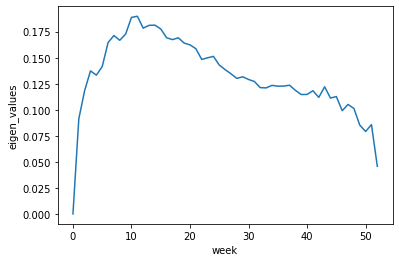

In [213]:
shifted['eigen_values'][0].plot(hue='n_eof')
plt.show()

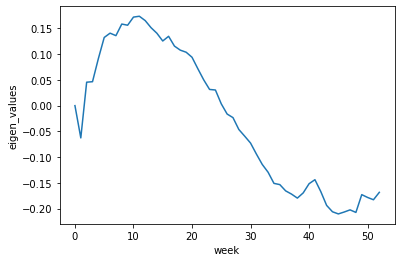

In [214]:
shifted['eigen_values'][1].plot(hue='n_eof')
plt.show()

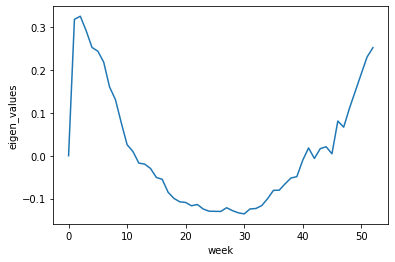

In [215]:
shifted['eigen_values'][2].plot(hue='n_eof')
plt.show()

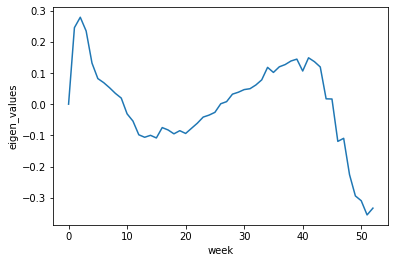

In [216]:
shifted['eigen_values'][3].plot(hue='n_eof')
plt.show()

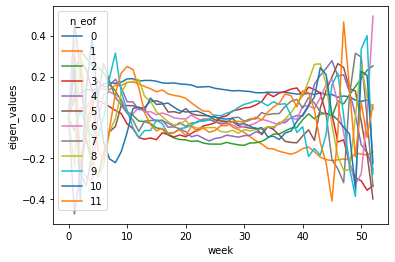

In [217]:
shifted['eigen_values'].plot(hue='n_eof')
plt.show()

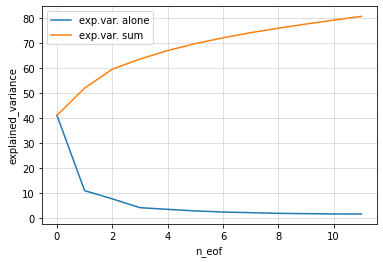

In [218]:
shifted['explained_variance'].plot(label='exp.var. alone')
shifted['explained_variance'].cumsum(dim='n_eof').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

For example PC1

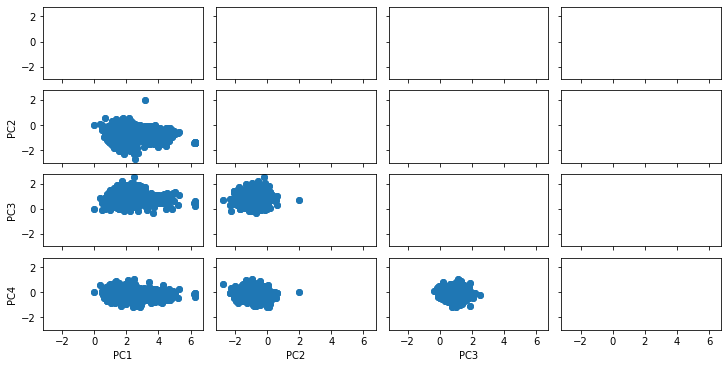

In [272]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,5), 
                       sharex=True, sharey=True, constrained_layout=True)

x0 = PC[0]
x1 = PC[1]
x2 = PC[2]
x3 = PC[3]

y0 = PC[0]
y1 = PC[1]
y2 = PC[2]
y3 = PC[3]

ax[1,0].scatter(x0, y1)
ax[1,0].set_ylabel('PC2')

ax[2,0].scatter(x0, y2)
ax[2,0].set_ylabel('PC3')

ax[3,0].scatter(x0, y3)
ax[3,0].set_xlabel('PC1')
ax[3,0].set_ylabel('PC4')

ax[2,1].scatter(x1, y2)

ax[3,1].scatter(x1, y3)
ax[3,1].set_xlabel('PC2')

ax[3,2].scatter(x2, y3)
ax[3,2].set_xlabel('PC3')

plt.show()